In [5]:
import numpy as np 
import matplotlib.pyplot as plt 

In [9]:
def gaussian_dist(val, mean, variance):
    temp = - ((val-mean)**2) / (2 * (variance))
    return (1 / (np.sqrt(2 * np.pi* variance)))* np.exp(temp)

def energy(bond_type, distance):
    if bond_type == 1:
        return gaussian_dist(distance, 0.6, .1)
    elif bond_type == 2:
        return gaussian_dist(distance, 0.05, 0.01) 
    else:
        return gaussian_dist(distance, 0.3, 0.02)

### Three functions operating at slightly different length-scales 

The three "bond-types" are in slightly different domains.

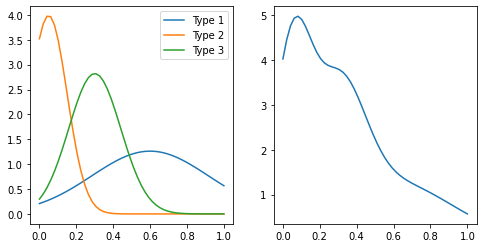

In [50]:
x = np.linspace(0,1)
t1 = energy(1,x)
t2 = energy(2,x)
t3 = energy(3,x)
combined = t1+t2+t3
fig,ax = plt.subplots(1,2,figsize = (8,4))
ax[0].plot(x, t1, label='Type 1')
ax[0].plot(x, t2, label='Type 2')
ax[0].plot(x, t3, label='Type 3')
ax[1].plot(x,combined, label='combined')
ax[0].legend()

In [119]:
x = .6 + np.random.normal(0, scale = .5, size = 10) / 4

## Generate train dataset 

The data is generated as a one-hot encoding of the bond type ([1,0,0], [0,1,0], or [0,0,1],) concatenated with the distance.  

In [3]:
def single_bond_generator(N = 100):
    energies = []
    bond_type = []
    r = np.random.uniform(size=N)
    dist = np.abs(.6 + np.random.normal(0, scale = .5, size = N) / 4)
    for i, num in enumerate(r):
        if (num < .3):
            energies.append(energy(1,dist[i]))
            temp = np.zeros((3))
            temp[0] = 1
            bond_type.append(temp)
        elif (num > .66):
            energies.append(energy(2,dist[i]))
            temp = np.zeros((3))
            temp[1] = 1
            bond_type.append(temp)
        else:
            energies.append(energy(3,dist[i]))
            temp = np.zeros((3))
            temp[2] = 1
            bond_type.append(temp)
    energies = np.array(energies)
    bond_type = np.array(bond_type)
    
    print(energies.shape)
    print(bond_type.shape)
    data = np.concatenate((bond_type, np.expand_dims(dist, axis=1)), axis=1)
    print(data.shape)
    
    return data, energies

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.utils.data as data_utils

In [44]:
X, y  = single_bond_generator(10000)
data_x = torch.from_numpy(X).float()
data_y = torch.from_numpy(y).float()
dataset = data_utils.TensorDataset(data_x,data_y)
loader = data_utils.DataLoader(dataset, batch_size = 128)

(10000,)
(10000, 3)
(10000, 4)


In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Sequential(
                        nn.Linear(4,16),
                        nn.ReLU(),
                        nn.Linear(16,16)
                    )
        self.out = nn.Linear(16,1)
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.out(x)
        return x

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for epoch in range(400):
    total = 0
    for batch, (x,y) in enumerate(loader):
        x = x.to(device)
        out = model(x)
        y = y.to(device).unsqueeze(dim=1)
        loss = loss_func(out, y)
        optimizer.zero_grad()
        loss.backward()
        total += loss.item()
        optimizer.step()
    if (epoch % 100 == 0):
        print(total / len(loader))

0.12630834951525247
0.0003168326081403036
0.00023941220763534353
0.00014838235173429676


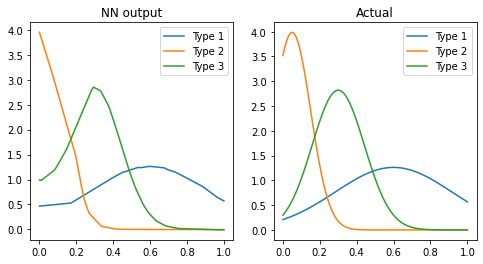

In [49]:
Num_test_samples = 100
x = torch.linspace(0,1, steps=Num_test_samples).unsqueeze(dim=-1)
class_1 = torch.zeros(Num_test_samples).long()
class_2 = torch.ones(Num_test_samples).long()
class_3 = 2*torch.ones(Num_test_samples).long()

data_1 = torch.cat((F.one_hot(class_1, num_classes=3),x), axis=1)
data_2 = torch.cat((F.one_hot(class_2, num_classes=3),x), axis=1)
data_3 = torch.cat((F.one_hot(class_3, num_classes=3),x), axis=1)

with torch.no_grad():
    t1 = model(data_1.float().to(device)).detach().cpu().numpy()
    t2 = model(data_2.float().to(device)).detach().cpu().numpy()
    t3 = model(data_3.float().to(device)).detach().cpu().numpy()
    
x = np.linspace(0,1, Num_test_samples)
r_t1 = energy(1,x)
r_t2 = energy(2,x)
r_t3 = energy(3,x)
combined = t1+t2+t3
fig,ax = plt.subplots(1,2,figsize = (8,4))
ax[0].plot(x, t1, label='Type 1')
ax[0].plot(x, t2, label='Type 2')
ax[0].plot(x, t3, label='Type 3')
ax[1].plot(x, r_t1, label='Type 1')
ax[1].plot(x, r_t2, label='Type 2')
ax[1].plot(x, r_t3, label='Type 3')
ax[0].set_title("NN output")
ax[1].set_title("Actual")
ax[0].legend()
ax[1].legend()